In [3]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

semesters = pd.read_csv('terminsstatus_17.txt', sep = '\t')
semesters.head()


,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr
0,E,1,0,20002,20002,15,-7,6.0,15,1
1,W,2,1,20112,20112,37,-7,15.0,37,1
2,D,3,1,20032,20032,21,-7,16.5,21,1
3,N,4,1,20112,20112,37,-7,30.0,37,1
4,W,5,1,20112,20112,37,-7,0.0,37,1


# Add columns for new features

## Previous semester (if it doesn't exist --> mean points)

In [4]:
delay_one_term = lambda x: x.shift(+1)
prev_semesters = semesters.apply(delay_one_term)
mean_points = semesters.poang_p.mean()

prev = []
for i,s in enumerate(semesters.lopnr):
    if s == prev_semesters.at[i,'lopnr']:
        prev.append(prev_semesters.at[i, 'poang_p'])
    else:
        prev.append(mean_points)
prev_points_pd = pd.DataFrame(prev)
semesters['prev_points'] = prev_points_pd
semesters.head()


,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1


## First semester 

In [5]:
lopnr_prev = 0
points_first_semester = []
for i, s in enumerate(semesters.lopnr):
    if s != lopnr_prev:
        p = semesters.at[i, 'poang_p']
        points_first_semester.append(p)
    else:
        points_first_semester.append(p)
    lopnr_prev = s
pfs_pd = pd.DataFrame(points_first_semester)
semesters['points_first_semester'] = pfs_pd
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0


# Accumulated points

In [10]:
lopnr_prev = 0
acc_points = []
for i, p in enumerate(semesters.lopnr):
    if p != lopnr_prev:
        acc_points.append(semesters.at[i,'poang_p'])
    else:
        acc_points.append(acc_points[i-1] + semesters.at[i,'poang_p'])
    lopnr_prev = p
acc_points_pd = pd.DataFrame(acc_points)
#acc_points_pd.head(20)
semesters['accumulated_points'] = acc_points_pd
semesters.head(40)

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester,accumulated_points
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0,6.0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0,15.0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5,16.5
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0,30.0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0,0.0
5,F,6,0,20082,20082,31,-7,0.0,31,1,16.1,0.0,0.0
6,D,7,0,20102,20102,35,-7,5.0,35,1,16.1,5.0,5.0
7,V,8,0,20092,20092,33,-7,0.0,33,1,16.1,0.0,0.0
8,B,9,1,20022,20022,19,-7,0.0,19,1,16.1,0.0,0.0
9,K,10,0,20122,20122,39,-7,18.5,39,1,16.1,18.5,18.5


# Amount of Zero-points semesters

In [16]:
pd.options.display.max_rows = 40
lopnr_prev = 0
zero_semesters = [0]*semesters.shape[0]
for i, s in enumerate(semesters.lopnr):
    if semesters.at[i,'poang_p'] == 0:
        if s != lopnr_prev:
            zero_semesters[i] += 1
        else:
            zero_semesters[i] = zero_semesters[i-1]+1
        lopnr_prev = s
zs_pd = pd.DataFrame(zero_semesters)
semesters['zero_semesters'] = zs_pd
semesters.head(1000)

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester,accumulated_points,zero_semesters
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0,6.0,0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0,15.0,0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5,16.5,0
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0,30.0,0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0,0.0,1
5,F,6,0,20082,20082,31,-7,0.0,31,1,16.1,0.0,0.0,1
6,D,7,0,20102,20102,35,-7,5.0,35,1,16.1,5.0,5.0,0
7,V,8,0,20092,20092,33,-7,0.0,33,1,16.1,0.0,0.0,1
8,B,9,1,20022,20022,19,-7,0.0,19,1,16.1,0.0,0.0,1
9,K,10,0,20122,20122,39,-7,18.5,39,1,16.1,18.5,18.5,0


# Preprocessa Features

In [19]:
def preprocess_features(semesters):
  """Prepares input features from Semesters

  Args:
    semesters: A Pandas DataFrame expected to contain data
      from terminer.txt.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = semesters[
    ["prev_points",
     "points_first_semester",
     "accumulated_points",
     "zero_semesters",]]
    
  processed_features = selected_features.copy()
  # Create a synthetic feature if needed.

  return processed_features

def preprocess_targets(semesters):
  """Prepares target features (i.e., labels) from semesters dataa set.

  Args:
    semesters: A Pandas DataFrame expected to contain data
      from the semesters dataset
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["poang_p"] = semesters["poang_p"]
  return output_targets

# Divide into training and test

In [20]:
# Shuffle the dataset
shuffled_semesters = semesters.sample(frac=1)
# Choose the first 12000 examples for training.

training_examples = preprocess_features(shuffled_semesters.head(12000))
training_targets = preprocess_targets(shuffled_semesters.head(12000))

# Choose the last 5000 examples for validation.
validation_examples = preprocess_features(shuffled_semesters.tail(5000))
validation_targets = preprocess_targets(shuffled_semesters.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,prev_points,points_first_semester,accumulated_points,zero_semesters
count,12000.0,12000.0,12000.0,12000.0
mean,16.4,18.0,125.6,2.8
std,14.1,9.2,93.2,6.0
min,0.0,0.0,0.0,0.0
25%,0.0,12.0,38.0,0.0
50%,16.1,19.0,113.8,0.0
75%,29.9,25.5,210.0,2.0
max,73.5,65.0,406.0,41.0


Validation examples summary:


,prev_points,points_first_semester,accumulated_points,zero_semesters
count,5000.0,5000.0,5000.0,5000.0
mean,16.3,17.9,122.8,2.7
std,14.0,9.2,93.0,5.9
min,0.0,0.0,0.0,0.0
25%,0.0,11.5,34.5,0.0
50%,16.1,18.0,106.5,0.0
75%,29.0,25.5,209.2,2.0
max,67.5,65.0,385.5,40.0


Training targets summary:


,poang_p
count,12000.0
mean,16.1
std,14.9
min,0.0
25%,0.0
50%,15.5
75%,30.0
max,73.5


Validation targets summary:


,poang_p
count,5000.0
mean,16.0
std,15.0
min,0.0
25%,0.0
50%,15.0
75%,30.0
max,83.0


# Correlation between features and target

In [21]:

correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["poang_p"]

correlation_dataframe.corr()

,prev_points,points_first_semester,accumulated_points,zero_semesters,target
prev_points,1.0,0.4,0.2,-0.5,0.5
points_first_semester,0.4,1.0,0.3,-0.3,0.4
accumulated_points,0.2,0.3,1.0,-0.2,0.2
zero_semesters,-0.5,-0.3,-0.2,1.0,-0.5
target,0.5,0.4,0.2,-0.5,1.0


# Train the model

In [22]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [23]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [24]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["poang_p"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["poang_p"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["poang_p"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 17.63
  period 01 : 15.99
  period 02 : 17.67
  period 03 : 15.88
  period 04 : 17.42
  period 05 : 15.72
  period 06 : 15.73
  period 07 : 14.90
  period 08 : 15.54
  period 09 : 14.73
Model training finished.


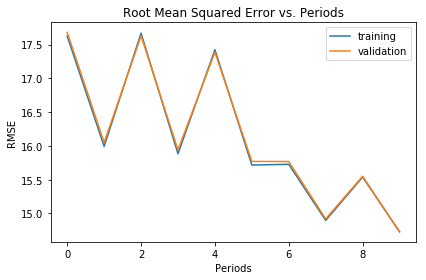

In [25]:
_ = train_model(
    learning_rate=0.01,
    steps=5,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)